In [6]:
%load_ext autoreload
%autoreload 2
from typing import List

import os
from copy import copy
from itertools import combinations, permutations
import pickle
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

In [7]:
from cube import Cube3D

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
cube = Cube3D(2)

In [10]:
cube.cube

array([[[1, 2],
        [3, 4]],

       [[5, 6],
        [7, 8]]])

In [11]:
cube.sort_loss()

0

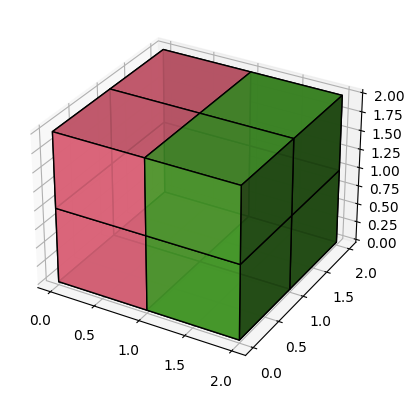

In [12]:
cube.plot()

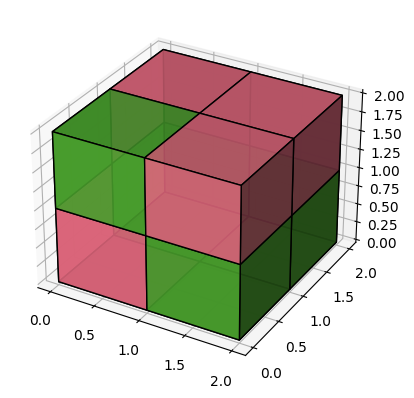

Sort loss for this state: 12


In [13]:
cube.mix(100)
cube.plot()
print(f'Sort loss for this state: {cube.sort_loss()}')

In [14]:
import networkx as nx

In [15]:
def load_data(dataset_size, num_steps, split_rate, prefix=''):
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_train.pkl', 'rb') as f:
        train_data = pickle.load(f)

    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_test.pkl', 'rb') as f:
        test_data = pickle.load(f)

    return train_data, test_data

In [16]:
train_set = set([str(x[0]) for x in load_data(10000, 1, 0.9, 'greedy_v1')[0]])

In [17]:
from copy import deepcopy

In [18]:
cube = Cube3D(2)
G = nx.Graph()

prev_states = [cube]
for _ in range(3):
    new_states = []
    for cube_state in prev_states:
        cube_state = deepcopy(cube_state)
        old_state = str(cube_state.flattened)
        for action in cube_state.get_actions_possible().keys():
            if action == 0:
                continue
            new_state = str(cube_state.mix(1).flattened)
            new_states.append(cube_state)
            G.add_node(old_state, color='blue' if new_state not in train_set else 'red')
            G.add_node(new_state, color='blue' if new_state not in train_set else 'red')
            G.add_edge(old_state, new_state)
    prev_states = new_states

In [19]:
G.nodes['[1 2 3 4 5 6 7 8]']['color'] = 'green'

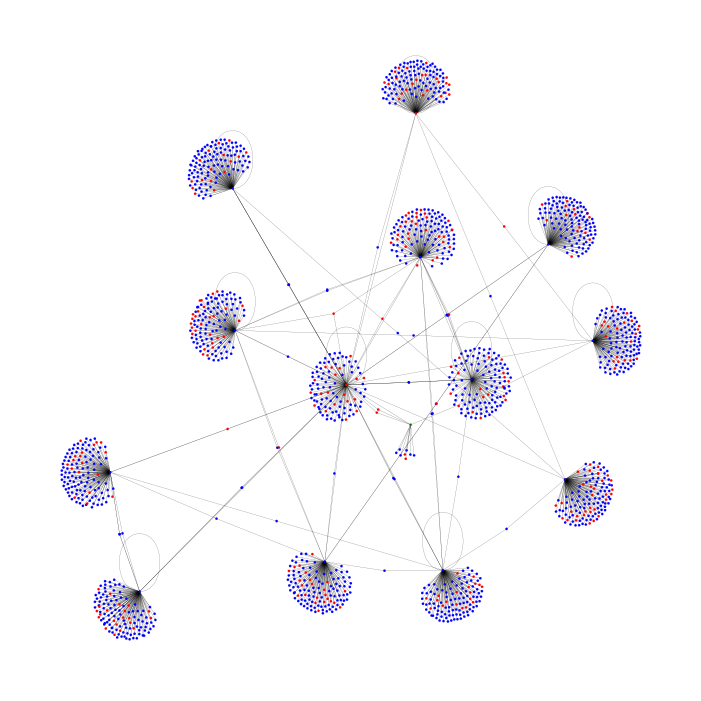

In [20]:
fig = plt.figure(1, figsize=(70, 70), dpi=10)
nx.draw(G, node_color=[G.nodes[x]['color'] for x in G.nodes])

## Prepare tree shaped train data

Input - reshaped to 1-D array cube. <br>
Output - best next action in terms of sort loss optimization (including "ideal"). <br><br>

Starting from the sorted state, we move randomly in the chaos.

In [21]:
# generate simple data
from copy import deepcopy
import pickle
import random


def generate_data(dataset_size, num_steps):
    DATA = []
    cube = Cube3D(2)
    output_array_size = len(cube.get_actions_possible().keys())
    for i in range(dataset_size):
        if i%100 == 0:
            print(f'{i} lines generated.')
        cube.mix(random.randint(0, 2))
        init_loss = cube.sort_loss()
        best_action = 0
        for actions in list(set(permutations(list(cube.get_actions_possible().keys())*num_steps, num_steps))):
            cp_cube = deepcopy(cube)
            for action in actions:
                cp_cube.apply_action(action)
            new_loss = cp_cube.sort_loss()
            if new_loss < init_loss:
                init_loss = new_loss
                best_action = actions[0]
        output = [0]*output_array_size
        output[best_action] = 1
        DATA.append((deepcopy(cube), output))
    return DATA


def split_data(data, split_rate=0.9):
    train_data = []
    test_data = []
    for row in data:
        input_data = row[0].flattened
        if random.random() < split_rate:
            train_data.append([input_data, row[1]])
        else:
            test_data.append([input_data, row[1]])
    return train_data, test_data


def dump_data(train_data, test_data, dataset_size, num_steps, split_rate, prefix=''):
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_train.pkl', 'wb') as f:
        pickle.dump(train_data, f)
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_test.pkl', 'wb') as f:
        pickle.dump(test_data, f)


def load_data(dataset_size, num_steps, split_rate, prefix=''):
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_train.pkl', 'rb') as f:
        train_data = pickle.load(f)

    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_test.pkl', 'rb') as f:
        test_data = pickle.load(f)

    return train_data, test_data


## 1 step optimization

In [22]:
# v1 is a simple attempt of using defined convex sort loss and 1/2/3 steps optimization.

DATASET_SIZE = 1000
STEPS = 2
SPLIT_RATE = 0.9
PREFIX = 'v2'

try:
    train_data, test_data = load_data(DATASET_SIZE, STEPS, SPLIT_RATE, PREFIX)
except:
    data = generate_data(DATASET_SIZE, STEPS)
    train_data, test_data = split_data(data, SPLIT_RATE)
    dump_data(train_data, test_data, DATASET_SIZE, STEPS, SPLIT_RATE, PREFIX)

0 lines generated.
100 lines generated.
200 lines generated.
300 lines generated.
400 lines generated.
500 lines generated.
600 lines generated.
700 lines generated.
800 lines generated.
900 lines generated.


In [23]:
class SorterNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(SorterNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [36]:
def run_testbed(cube_size, dataset_size, steps, split_rate, prefix, hidden_size, random_step_prob):
    try:
        train_data, test_data = load_data(dataset_size, steps, split_rate, prefix)
    except:
        data = generate_data(dataset_size, steps)
        train_data, test_data = split_data(data, split_rate)
        dump_data(train_data, test_data, dataset_size, steps, split_rate, prefix)
    # prepare model
    input_train_data = torch.tensor([x[0] for x in train_data], dtype=torch.float32)
    output_train_data = torch.tensor([x[1] for x in train_data], dtype=torch.float32)
    PATH = f'../models/{cube_size}_{prefix}_{steps}_{dataset_size}_{split_rate}_h{hidden_size}_model.pkl'
    input_size = input_train_data.shape[1]
    output_size = output_train_data.shape[1]
    model = None
    if not os.path.exists(PATH):
        if prefix == 'greedy_v3':
            model = SorterNN(input_size, hidden_size, output_size)
        else:
            raise ValueError('Unknown test prefix.')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 5000
        for epoch in range(num_epochs):
            outputs = model(input_train_data)
            loss = criterion(outputs, output_train_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        torch.save(model.state_dict(), PATH)
    else:
        model = SorterNN(input_size, hidden_size, output_size)
        model.load_state_dict(torch.load(PATH))
        model.eval()
    # evaluate
    RES = {
        'train_errors': None,
        'train_mistakes': None,
        'test_errors': None,
        'test_mistakes': None,
        'sort_stats': None,
    }
    test_wrong = 0
    test_errors = 0
    for test_row in test_data:
        test_input = torch.tensor([test_row[0]], dtype=torch.float32)
        predicted_output = model(test_input).round()
        try:
            if test_row[1].index(1) != predicted_output.detach().numpy()[0].tolist().index(1):
                test_wrong += 1
        except:
            test_errors += 1
    train_wrong = 0
    train_errors = 0
    for test_row in train_data:
        test_input = torch.tensor([test_row[0]], dtype=torch.float32)
        predicted_output = model(test_input).round()
        try:
            if test_row[1].index(1) != predicted_output.detach().numpy()[0].tolist().index(1):
                train_wrong += 1
        except:
            train_errors += 1
    # test the sorting
    max_iter = 100000
    sort_stats = {
        'max_iter': [],
        'init_loss': [],
        'output_loss': [],
    }
    for t in range(100):
        print(t)
        cube = Cube3D(cube_size)
        cube.mix(2)
        init_loss = cube.sort_loss()
        v = cube.sort_loss()
        i = 0
        while True:
            test_input = torch.tensor([cube.flattened], dtype=torch.float32)
            predicted_output = model(test_input)
            try:
                if random.random() < random_step_prob:
                    action = predicted_output.detach().numpy().astype(int).tolist()[0].index(1)
                else:
                    action = random.randint(0, len(cube.action_keys)-1)
            except:
                action = random.randint(0, len(cube.action_keys)-1)
            cube.apply_action(action)
            v = cube.sort_loss()
            i += 1
            if i > max_iter or v == 0:
                sort_stats['init_loss'].append(init_loss)
                sort_stats['max_iter'].append(i)
                sort_stats['output_loss'].append(v)
                break
    RES['train_errors'] = train_errors
    RES['train_mistakes'] = train_wrong
    RES['test_errors'] = test_errors
    RES['test_mistakes'] = test_wrong
    RES['sort_stats'] = sort_stats
    return RES
    

In [37]:
TESTS = []

CUBE_SIZES = [2]
DATASET_SIZES = [1000]
STEPS = [1, 2]
SPLIT_RATES = [0.9]
PREFIXES = ['greedy_v3']
HIDDEN_SIZES = [64]
RANDOM_STEP_PROBS = [0.5, 0.7, 0.9, 0.95]

for cube_size in CUBE_SIZES:
    for dataset_size in DATASET_SIZES:
        for step in STEPS:
            for split_rate in SPLIT_RATES:
                for prefix in PREFIXES:
                    for hidden_size in HIDDEN_SIZES:
                        for random_step_prob in RANDOM_STEP_PROBS:
                            TESTS.append(
                                {
                                    'cube_size': cube_size,
                                    'dataset_size': dataset_size,
                                    'step': step,
                                    'split_rate': split_rate,
                                    'prefix': prefix,
                                    'hidden_size': hidden_size,
                                    'random_step_prob': random_step_prob,
                                }
                            )

In [38]:
len(TESTS)

8

In [39]:
RESULTS = {
    'cube_size': [],
    'dataset_size': [],
    'step': [],
    'split_rate': [],
    'prefix': [],
    'hidden_size': [],
    'random_step_prob': [],
    'train_errors': [],
    'train_mistakes': [],
    'test_errors': [],
    'test_mistakes': [],
    'median_max_iter': [],
    'median_init_loss': [],
    'median_output_loss': [],
    'failed_to_sort': [],
}
for ti, TEST in enumerate(TESTS):
    print(f'--------------------test number {ti}---------------\n')
    cube_size = TEST['cube_size']
    dataset_size = TEST['dataset_size']
    step = TEST['step']
    split_rate = TEST['split_rate']
    prefix = TEST['prefix']
    hidden_size = TEST['hidden_size']
    random_step_prob = TEST['random_step_prob']
    TEST_RESULTS_PATH = f'../test_results/cube{cube_size}_{dataset_size}_{step}_{split_rate}_{prefix}_{hidden_size}_{random_step_prob}.pkl'

    RES = None
    if os.path.exists(TEST_RESULTS_PATH):
        with open(TEST_RESULTS_PATH, 'rb') as f:
            RES = pickle.load(f)
    else:
        RES = run_testbed(cube_size, dataset_size, step, split_rate, prefix, hidden_size, random_step_prob)
        with open(TEST_RESULTS_PATH, 'wb') as f:
            pickle.dump(RES, f)
    RESULTS['cube_size'].append(cube_size)
    RESULTS['dataset_size'].append(dataset_size)
    RESULTS['step'].append(step)
    RESULTS['split_rate'].append(split_rate)
    RESULTS['prefix'].append(prefix)
    RESULTS['hidden_size'].append(hidden_size)
    RESULTS['random_step_prob'].append(random_step_prob)
    RESULTS['train_errors'].append(RES['train_errors'])
    RESULTS['train_mistakes'].append(RES['train_mistakes'])
    RESULTS['test_errors'].append(RES['test_errors'])
    RESULTS['test_mistakes'].append(RES['test_mistakes'])
    RESULTS['median_max_iter'].append(sorted(RES['sort_stats']['max_iter'])[len(RES['sort_stats']['max_iter'])//2])
    RESULTS['median_init_loss'].append(sorted(RES['sort_stats']['init_loss'])[len(RES['sort_stats']['init_loss'])//2])
    RESULTS['median_output_loss'].append(sorted(RES['sort_stats']['output_loss'])[len(RES['sort_stats']['output_loss'])//2])
    RESULTS['failed_to_sort'].append(len(list(filter(lambda x: x > 100000 - 1, RES['sort_stats']['max_iter']))))
    print('\n\n')


--------------------test number 0---------------

0 lines generated.
100 lines generated.
200 lines generated.
300 lines generated.
400 lines generated.
500 lines generated.
600 lines generated.
700 lines generated.
800 lines generated.
900 lines generated.
Epoch [5000/5000], Loss: 1.8164
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99



--------------------test number 1---------------

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99



--------------------test number 2---------------

0
1
2
3
4
5
6
7
8
9
10
1

In [ ]:
pd.DataFrame(RES['sort_stats']).sort_values(by='max_iter', ascending=True)

,max_iter,init_loss,output_loss
2,66,12,0
34,68,6,0
50,72,12,0
65,80,16,0
40,136,18,0
...,...,...,...
64,9808,4,0
37,11035,18,0
18,11496,12,0
72,11556,18,0


In [ ]:
df = pd.DataFrame(RESULTS).sort_values(by='median_max_iter')
df

,cube_size,dataset_size,step,split_rate,prefix,hidden_size,random_step_prob,train_errors,train_mistakes,test_errors,test_mistakes,median_max_iter,median_init_loss,median_output_loss,failed_to_sort
7,2,1000,2,0.9,greedy_v2,64,0.95,25,238,2,25,1695,14,0,0
6,2,1000,2,0.9,greedy_v2,64,0.90,25,238,2,25,2442,14,0,0
5,2,1000,2,0.9,greedy_v2,64,0.70,25,238,2,25,2554,14,0,0
1,2,1000,1,0.9,greedy_v2,64,0.70,12,137,0,21,3057,14,0,0
2,2,1000,1,0.9,greedy_v2,64,0.90,12,137,0,21,3324,14,0,0
3,2,1000,1,0.9,greedy_v2,64,0.95,12,137,0,21,3382,14,0,0
4,2,1000,2,0.9,greedy_v2,64,0.50,25,238,2,25,3775,14,0,0
0,2,1000,1,0.9,greedy_v2,64,0.50,12,137,0,21,4383,14,0,0


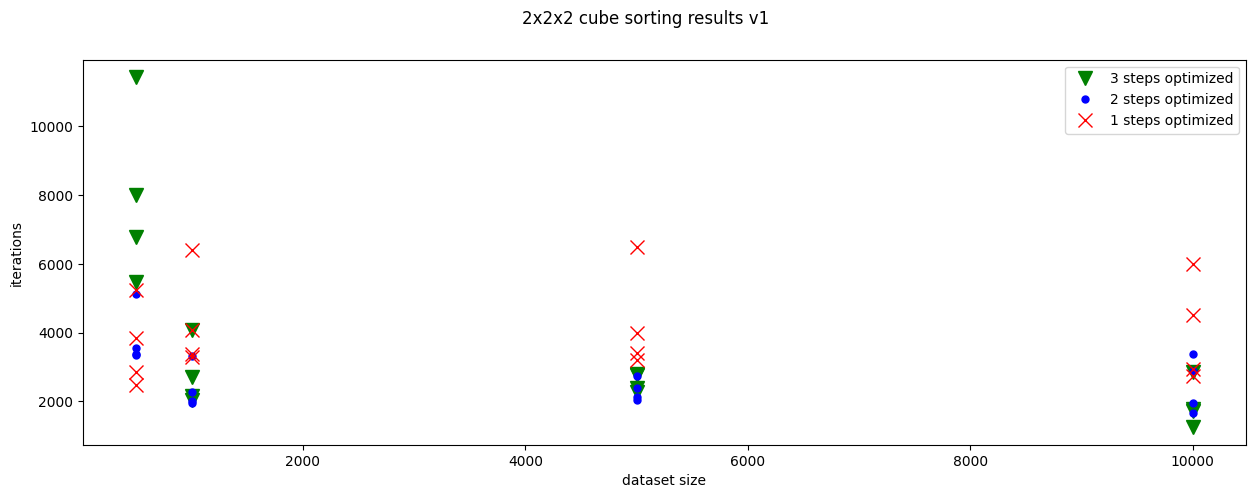

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

plots = [
    (3, 0.5, 'vg'),
    (3, 0.7, 'vg'),
    (3, 0.9, 'vg'),
    (3, 0.95, 'vg'),
    (2, 0.5, '.b'),
    (2, 0.7, '.b'),
    (2, 0.9, '.b'),
    (2, 0.95, '.b'),
    (1, 0.5, 'xr'),
    (1, 0.7, 'xr'),
    (1, 0.9, 'xr'),
    (1, 0.95, 'xr'),
]

for i, (step, rs_prob, marker) in enumerate(plots):
    df1 = df.loc[(df['step'] == step) & (df['random_step_prob'] == rs_prob)]
    label = None
    if (i+1)%4==0:
        label = f'{step} steps optimized'
    ax.plot(df1['dataset_size'], df1['median_max_iter'], marker, label=label, markersize=10)

plt.xlabel('dataset size')
plt.ylabel('iterations')
plt.suptitle('2x2x2 cube sorting results v1')
plt.legend()

In [90]:
# todo:
# - concentric dataset (100% data close to (0, 0), and less after)
# - deep search data